<a href="https://colab.research.google.com/github/Lazydayz137/Notebooks/blob/main/trademaster_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quickstart colab for TradeMaster

see [github.com/TradeMaster-NTU/TradeMaster](https://github.com/TradeMaster-NTU/TradeMaster) for more details

In [ ]:
# @title Download TradeMaster Package
!git clone https://github.com/TradeMaster-NTU/TradeMaster.git
%cd './TradeMaster'

Cloning into 'TradeMaster'...
remote: Enumerating objects: 8919, done.
remote: Counting objects: 100% (2358/2358), done.
remote: Compressing objects: 100% (664/664), done.
remote: Total 8919 (delta 1636), reused 2272 (delta 1559), pack-reused 6561
Receiving objects: 100% (8919/8919), 394.81 MiB | 27.24 MiB/s, done.
Resolving deltas: 100% (5032/5032), done.
Updating files: 100% (420/420), done.
/content/TradeMaster


In [ ]:
# @title Install Packages
%%capture
!pip install setuptools==66
!pip install dtaidistance
!pip install fastdtw
!pip install wheel==0.38.4
!pip install -r requirements.txt

# Tutorial 1: EIIE for US Stock Trading
We show how to train a profitable RL agent on portfolio managemnt with EIIE algorithm on US stock market.

## Step 1: Import Packages
Modify the system path and load the corresponding packages and functions

In [ ]:
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)
import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
from trademaster.utils import plot
from trademaster.utils import set_seed
set_seed(2023)

## Step 2: Load Configs
Load default config from the file configs/portfolio_management/portfolio_management_dj30_eiie_eiie_adam_mse.py

In [ ]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "TradeMaster", "configs", "portfolio_management", "portfolio_management_dj30_eiie_eiie_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")

args, _= parser.parse_known_args()
cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

## Step 3: Build Dataset

In [ ]:
dataset = build_dataset(cfg)

## Step 4: Build Reinforcement Learning Environments

In [ ]:
train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))
train_environment.df.head()

,date,open,high,low,close,adjcp,tic,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
0,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.643501,AAPL,-0.008320,0.002999,-0.010062,-0.143726,0.005374,-0.010348,-0.011415,0.002751,-0.061124,-0.072128,-0.126481
0,2012-01-04,64.099998,64.129997,63.400002,63.759998,49.393219,AMGN,0.005332,0.005803,-0.005646,-0.225326,-0.005459,0.007794,-0.008521,-0.008222,-0.017393,-0.031253,-0.042012
0,2012-01-04,48.020000,48.380001,47.400002,48.240002,41.672607,AXP,-0.004561,0.002902,-0.017413,-0.136140,-0.003100,0.004561,-0.004885,-0.017185,-0.029824,-0.045096,-0.052918
0,2012-01-04,74.099998,74.599998,73.589996,74.330002,60.821106,BA,-0.003094,0.003632,-0.009956,-0.181742,0.001482,0.002922,-0.007421,-0.004776,-0.002812,-0.013054,-0.001687
0,2012-01-04,93.410004,95.510002,93.410004,94.849998,70.945084,CAT,-0.015182,0.006958,-0.015182,-0.252029,0.009257,0.010322,-0.004803,-0.010627,-0.001714,-0.005438,0.006133


## Step 5: Build Net
Update information on the state and action dimension. Crreate networks and optimizer for EIIE.

In [ ]:
action_dim = train_environment.action_dim # 29
state_dim = train_environment.state_dim # 11
input_dim = len(train_environment.tech_indicator_list)
time_steps = train_environment.time_steps

cfg.act.update(dict(input_dim=input_dim, time_steps=time_steps))
cfg.cri.update(dict(input_dim=input_dim, action_dim= action_dim, time_steps=time_steps))

act = build_net(cfg.act)
cri = build_net(cfg.cri)
act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
cri_optimizer = build_optimizer(cfg, default_args=dict(params=cri.parameters()))

## Step 6: Build Loss Function

In [ ]:
criterion = build_loss(cfg)

## Step 7: Build Transition

In [ ]:
transition = build_transition(cfg)

## Step 8: Build Agent

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = build_agent(cfg, default_args=dict(action_dim=action_dim,state_dim=state_dim,time_steps = time_steps,act=act,cri=cri,act_optimizer=act_optimizer,cri_optimizer = cri_optimizer,criterion=criterion,transition = transition,device = device))

## Step 9: Build Trainer
Build trainer from config and create work directionary to save the result, model and config

In [ ]:
trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))
work_dir = os.path.join(ROOT, "TradeMaster", cfg.trainer.work_dir)

if not os.path.exists(work_dir):
    os.makedirs(work_dir)
cfg.dump(osp.join(work_dir, osp.basename(args.config)))

## Step 10: RL Agent Training
Train the EIIE agent based on the config and save results in workdir

Train Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| 180.462983%  |   1.141236  | 0.756977%  |  15.019364%  |
+--------------+-------------+------------+--------------+
Valid Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  9.595924%   |   0.450400  | 2.141278%  |  31.037728%  |
+--------------+-------------+------------+--------------+
Train Episode: [2/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| 180.459091%  |   1.141222  | 0.756976%  |  15.019624%  |
+--------------+-------------+------------+--------------+
Valid Episode: [2/2]
+--------------+-------------+-

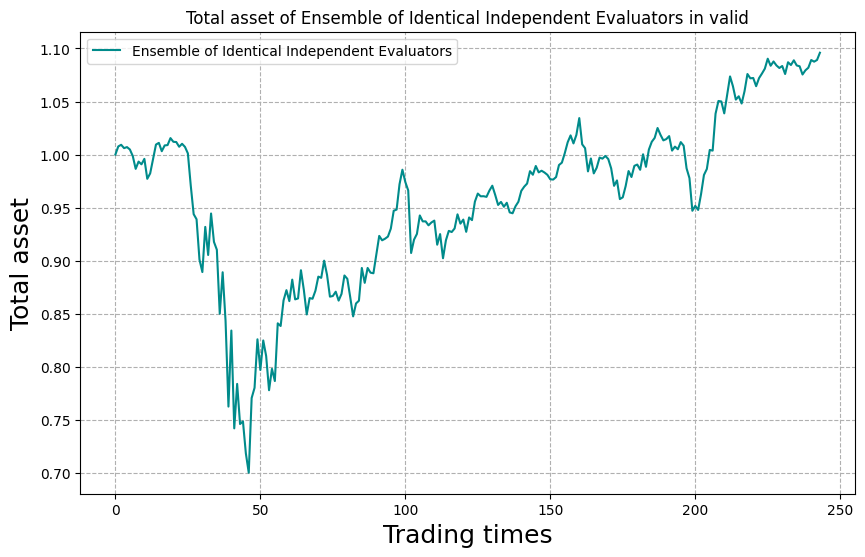

In [ ]:
trainer.train_and_valid()

## Step 11: RL Agent Testing

Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  14.641354%  |   1.304288  | 0.718877%  |  6.743508%   |
+--------------+-------------+------------+--------------+


array([ 0.00000000e+00,  2.81448321e-03,  8.03892223e-03, -3.98082981e-04,
       -7.15840075e-03, -7.65107363e-04,  1.97788939e-04, -1.77132718e-02,
        9.11214433e-03, -1.90881986e-02,  6.04913615e-03,  1.32273919e-02,
        1.00577427e-03,  1.16116106e-02,  4.68778788e-03,  7.33732859e-03,
       -9.74644272e-04,  5.81719502e-04, -1.90038981e-05,  1.48685174e-03,
        8.39304488e-04,  4.19099104e-03, -6.56883352e-03, -8.37538988e-04,
        3.09448099e-04,  1.47393847e-04,  1.06563597e-02, -1.54154629e-02,
       -1.49192034e-02,  1.76155380e-02, -5.30429812e-03, -4.02968009e-03,
       -1.02486468e-02,  1.86495906e-02,  8.50508042e-03,  1.73841891e-03,
        1.44365916e-02,  4.28859068e-03,  7.32362366e-03,  6.82817516e-03,
       -2.67799880e-03,  3.46726516e-03, -7.60043651e-03, -5.75153451e-03,
        5.00451862e-03, -7.07692709e-03, -1.03912329e-03,  5.81102733e-03,
        1.51164727e-02,  3.79508722e-03, -4.57823579e-03, -1.54122825e-03,
        4.47302616e-03,  

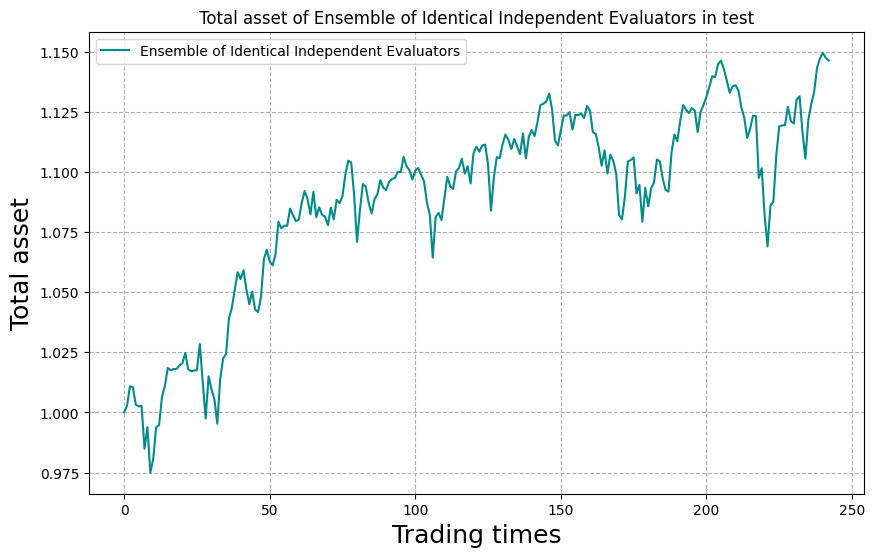

In [ ]:
trainer.test()

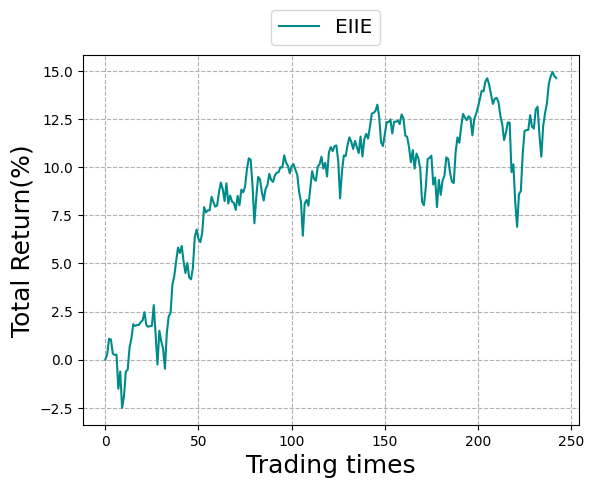

In [ ]:
plot(trainer.test_environment.save_asset_memory(),alg="EIIE")

# Tutorial 2: DeepScalper for BTC Trading
We show how to train DeepScalper on BTC trading.

## Step 1: Import Packages
Modify the system path and load the corresponding packages and functions

In [ ]:
import os
import sys

import warnings
warnings.filterwarnings("ignore")

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)

import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
from trademaster.utils import plot
from trademaster.utils import set_seed
set_seed(2023)

## Step 2: Load Configs
Load default config from the file configs/algorithmic_trading/algorithmic_trading_BTC_deepscalper_deepscalper_adam_mse.py

In [ ]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "TradeMaster", "configs", "algorithmic_trading", "algorithmic_trading_BTC_deepscalper_deepscalper_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")
args, _= parser.parse_known_args()

cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

## Step 3: Build Dataset

In [ ]:
dataset = build_dataset(cfg)

## Step 4: Build Reinforcement Learning Environments
Build environments based on cfg and predefined dataset

In [ ]:
train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))
train_environment.df.head()

,Unnamed: 0,tic,date,high,low,open,close,adjcp,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
300,300,BTC,2014-02-23 23:59:59,639.909973,599.700012,606.469971,605.820007,605.820007,0.001073,0.056271,-0.010102,0.0,0.000661,-0.021303,0.014655,0.038817,0.093376,0.147437,0.184472
301,301,BTC,2014-02-24 23:59:59,607.609985,538.700012,606.039978,546.320007,546.320007,0.109313,0.112187,-0.013948,0.0,-0.098214,0.057205,0.103988,0.135288,0.186680,0.252438,0.294724
302,302,BTC,2014-02-25 23:59:59,541.380005,420.410004,540.239990,538.710022,538.710022,0.002840,0.004956,-0.219599,0.0,-0.013930,0.065668,0.098754,0.133713,0.178086,0.248508,0.291569
303,303,BTC,2014-02-26 23:59:59,603.799988,532.580017,537.039978,582.690002,582.690002,-0.078344,0.036229,-0.085998,0.0,0.081639,-0.011838,0.009998,0.037906,0.072104,0.137119,0.183290
304,304,BTC,2014-02-27 23:59:59,594.049988,566.619995,581.650024,578.770020,578.770020,0.004976,0.026401,-0.020993,0.0,-0.006727,-0.014355,0.008632,0.036533,0.067821,0.127778,0.177843


## Step 5: Build Net
Update information about the state and action dimension. Create networks and optimizer for DeepScalper

In [ ]:
action_dim = train_environment.action_dim
state_dim = train_environment.state_dim

cfg.act.update(dict(action_dim=action_dim, state_dim=state_dim))
act = build_net(cfg.act)
act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
if cfg.cri:
    cfg.cri.update(dict(action_dim=action_dim, state_dim=state_dim))
    cri = build_net(cfg.cri)
    cri_optimizer = build_optimizer(cfg, default_args=dict(params=cri.parameters()))
else:
    cri = None
    cri_optimizer = None

## Step 6: Build Loss

In [ ]:
criterion = build_loss(cfg)

## Step 7: Build Transition

In [ ]:
transition = build_transition(cfg)

## Step 8: Build Agent

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = build_agent(cfg, default_args=dict(action_dim = action_dim,state_dim = state_dim,act = act,cri = cri,act_optimizer = act_optimizer,cri_optimizer = cri_optimizer, criterion = criterion,transition = transition,device=device))

## Step 9: Build Trainer
Build trainer from config and create work directionary to save the result, model and config

In [ ]:
trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))

## Step 10: Train the RL Agent
Train the trainer based on the config and save results in workdir

Train Episode: [1/20]
+--------------+
| Total Return |
+--------------+
| -108.076944% |
+--------------+
Valid Episode: [1/20]
+--------------+
| Total Return |
+--------------+
| -193.080913% |
+--------------+
Train Episode: [2/20]
+--------------+
| Total Return |
+--------------+
| -81.925242%  |
+--------------+
Valid Episode: [2/20]
+--------------+
| Total Return |
+--------------+
|  0.662902%   |
+--------------+
Train Episode: [3/20]
+--------------+
| Total Return |
+--------------+
| -68.145846%  |
+--------------+
Valid Episode: [3/20]
+--------------+
| Total Return |
+--------------+
| -193.080913% |
+--------------+
Train Episode: [4/20]
+--------------+
| Total Return |
+--------------+
| -88.946340%  |
+--------------+
Valid Episode: [4/20]
+--------------+
| Total Return |
+--------------+
| -193.080913% |
+--------------+
Train Episode: [5/20]
+--------------+
| Total Return |
+--------------+
| -93.803309%  |
+--------------+
Valid Episode: [5/20]
+--------------

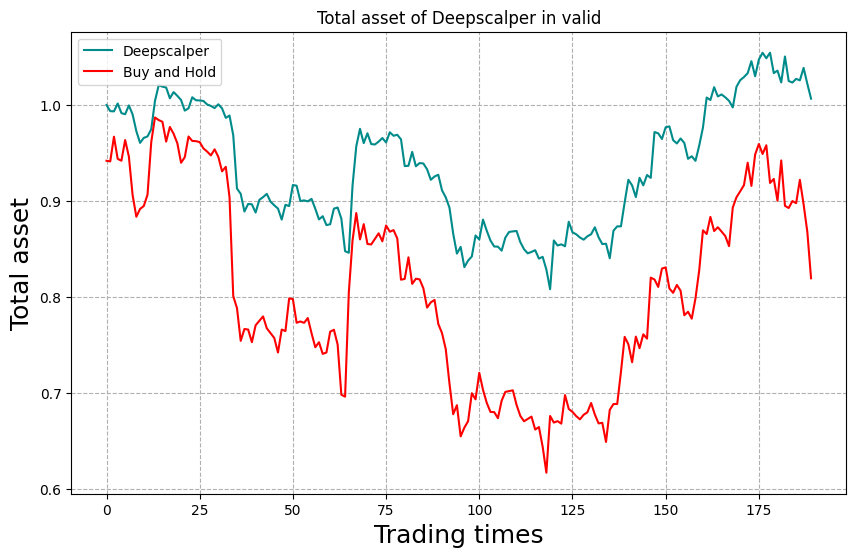

In [ ]:
trainer.train_and_valid()

## Step 11: RL Agent Testing

Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  20.569048%  |   0.494667  | 2.276165%  |  50.801280%  |
+--------------+-------------+------------+--------------+


array([ 0.00000000e+00,  1.12430176e+02, -5.05580078e+02,  1.92089355e+02,
        5.34240234e+02,  4.60465088e+03,  4.02597656e+01,  6.31961914e+02,
        2.74296094e+03, -2.43396387e+03, -1.25264062e+03,  2.35197070e+03,
        1.04711719e+03,  4.96368457e+03,  3.98000000e+02, -8.38081055e+02,
        1.02735938e+03,  5.36634082e+03, -6.81407812e+03,  3.05038672e+03,
       -2.35567969e+03,  2.53001465e+03,  5.64796875e+02, -1.24971191e+03,
       -9.72320312e+02,  8.18371094e+02,  4.06352344e+03, -3.01704102e+02,
        1.25912500e+03, -1.42345410e+03, -2.25432031e+03, -9.67326172e+02,
        7.22875000e+02, -1.96867480e+03, -4.81960156e+03,  4.43795898e+02,
        1.75240625e+03, -6.43535156e+01, -1.65128125e+03, -9.90848633e+02,
       -2.19608203e+03,  1.40984912e+03, -3.03203125e+01,  2.39463281e+03,
       -7.54078125e+02, -3.39489404e+03, -3.87167969e+03,  2.65680176e+02,
       -8.57597656e+02, -1.11834229e+03,  9.87226562e+01, -2.09006982e+03,
        2.69279688e+03, -

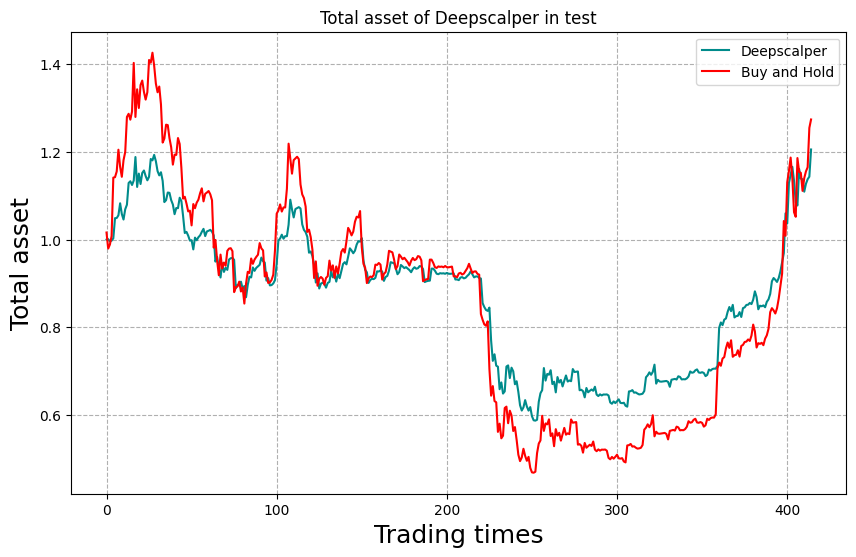

In [ ]:
trainer.test()

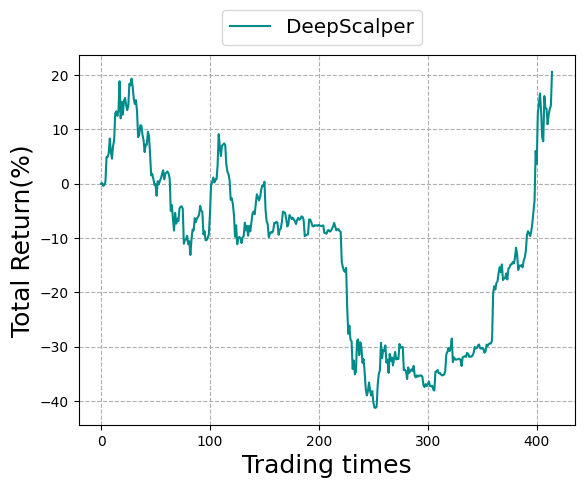

In [ ]:
plot(trainer.test_environment.save_asset_memory(),alg="DeepScalper")

# Tutorial 3: SARL for Portfolio Management on DJ30
This tutorial is to demonstrate an example of using SARL to do portfolio management on DJ30

## Step1: Import Packages

In [ ]:
import warnings

warnings.filterwarnings("ignore")
import sys
from pathlib import Path
import os
import torch

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)
from trademaster.utils import plot
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.datasets.builder import build_dataset
from trademaster.trainers.builder import build_trainer
from trademaster.utils import set_seed
set_seed(2023)



## Step2: Import Configs

In [ ]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "TradeMaster", "configs", "portfolio_management", "portfolio_management_dj30_sarl_sarl_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")
args, _ = parser.parse_known_args()

cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

## Step3: Build Dataset

In [ ]:
dataset = build_dataset(cfg)

## Step4: Build Trainer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
work_dir = os.path.join(ROOT, "TradeMaster", cfg.trainer.work_dir)

if not os.path.exists(work_dir):
    os.makedirs(work_dir)
cfg.dump(osp.join(work_dir, osp.basename(args.config)))

trainer = build_trainer(cfg, default_args=dict(dataset=dataset, device = device))

## Step5: Train and Valid

(f pid=1695) Train Episode: [1/2]
(f pid=1695) Valid Episode: [1/2]
(f pid=1695) +--------------+-------------+------------+--------------+
(f pid=1695) | Total Return | Sharp Ratio | Volatility | Max Drawdown |
(f pid=1695) +--------------+-------------+------------+--------------+
(f pid=1695) |  9.509114%   |   0.434929  | 2.372292%  |  35.112268%  |
(f pid=1695) +--------------+-------------+------------+--------------+
(f pid=1695) Train Episode: [2/2]
(f pid=1695) Valid Episode: [2/2]
(f pid=1695) +--------------+-------------+------------+--------------+
(f pid=1695) | Total Return | Sharp Ratio | Volatility | Max Drawdown |
(f pid=1695) +--------------+-------------+------------+--------------+
(f pid=1695) |  12.366160%  |   0.513676  | 2.227760%  |  32.524106%  |
(f pid=1695) +--------------+-------------+------------+--------------+


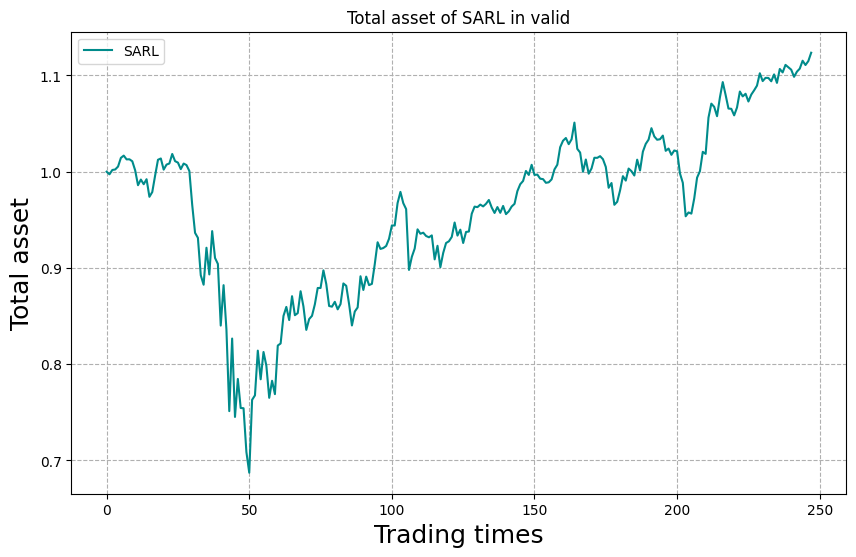

In [ ]:
import ray
from ray.tune.registry import register_env
from trademaster.environments.portfolio_management.sarl_environment import PortfolioManagementSARLEnvironment
def env_creator(env_name):
    if env_name == 'portfolio_management_sarl':
        env = PortfolioManagementSARLEnvironment
    else:
        raise NotImplementedError
    return env
ray.init(ignore_reinit_error=True)
register_env("portfolio_management_sarl", lambda config: env_creator("portfolio_management_sarl")(config))
trainer.train_and_valid()

## Step 6: Test

(f pid=8601) Test Best Episode
(f pid=8601) +--------------+-------------+------------+--------------+
(f pid=8601) | Total Return | Sharp Ratio | Volatility | Max Drawdown |
(f pid=8601) +--------------+-------------+------------+--------------+
(f pid=8601) |  18.434672%  |   1.505286  | 0.755693%  |  6.833814%   |
(f pid=8601) +--------------+-------------+------------+--------------+


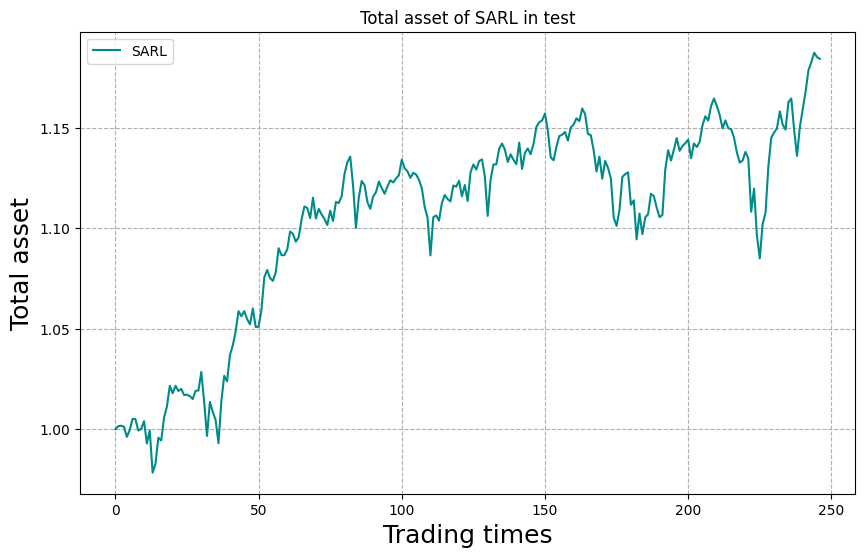

In [ ]:
import ray
from ray.tune.registry import register_env
from trademaster.environments.portfolio_management.sarl_environment import PortfolioManagementSARLEnvironment
def env_creator(env_name):
    if env_name == 'portfolio_management_sarl':
        env = PortfolioManagementSARLEnvironment
    else:
        raise NotImplementedError
    return env
ray.init(ignore_reinit_error=True)
register_env("portfolio_management_sarl", lambda config: env_creator("portfolio_management_sarl")(config))
trainer.test()

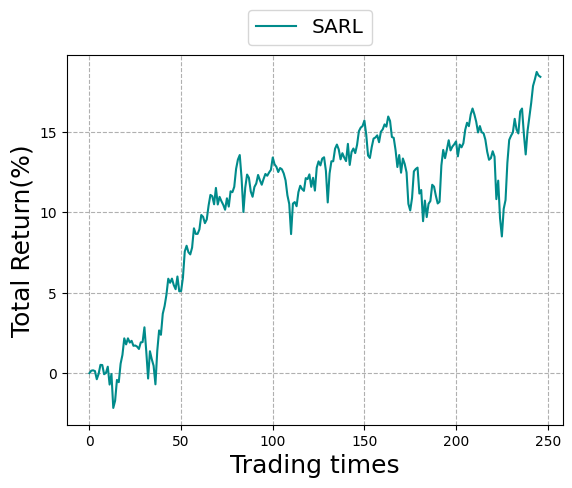

In [ ]:
plot(trainer.test_environment.save_asset_memory(),alg="SARL")

# Tutorial 4: PPO for Portfolio Management
This tutorial is to demonstrate an example of using PPO to do portfolio management

## Step1: Import Packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import sys
from pathlib import Path
import os
import torch

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)

import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.utils import plot
from trademaster.utils import set_seed
set_seed(2023)

## Step2: Import Configs

In [ ]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "TradeMaster", "configs", "portfolio_management", "portfolio_management_exchange_ppo_ppo_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")
args, _ = parser.parse_known_args()

cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

## Step3: Build Dataset

In [ ]:
dataset = build_dataset(cfg)

## Step4: Build Trainer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
work_dir = os.path.join(ROOT, "TradeMaster", cfg.trainer.work_dir)

if not os.path.exists(work_dir):
    os.makedirs(work_dir)
cfg.dump(osp.join(work_dir, osp.basename(args.config)))

trainer = build_trainer(cfg, default_args=dict(dataset=dataset, device = device))

## Step5: Train and Valid

(f pid=8601) Train Episode: [1/10]
(f pid=8601) Valid Episode: [1/10]
(f pid=8601) +--------------+-------------+------------+--------------+
(f pid=8601) | Total Return | Sharp Ratio | Volatility | Max Drawdown |
(f pid=8601) +--------------+-------------+------------+--------------+
(f pid=8601) |  2.395405%   |   0.244989  | 0.346206%  |  7.279630%   |
(f pid=8601) +--------------+-------------+------------+--------------+
(f pid=8601) Train Episode: [2/10]
(f pid=8601) Valid Episode: [2/10]
(f pid=8601) +--------------+-------------+------------+--------------+
(f pid=8601) | Total Return | Sharp Ratio | Volatility | Max Drawdown |
(f pid=8601) +--------------+-------------+------------+--------------+
(f pid=8601) |  2.687592%   |   0.271531  | 0.345633%  |  7.103427%   |
(f pid=8601) +--------------+-------------+------------+--------------+
(f pid=8601) Train Episode: [3/10]
(f pid=8601) Valid Episode: [3/10]
(f pid=8601) +--------------+-------------+------------+--------------

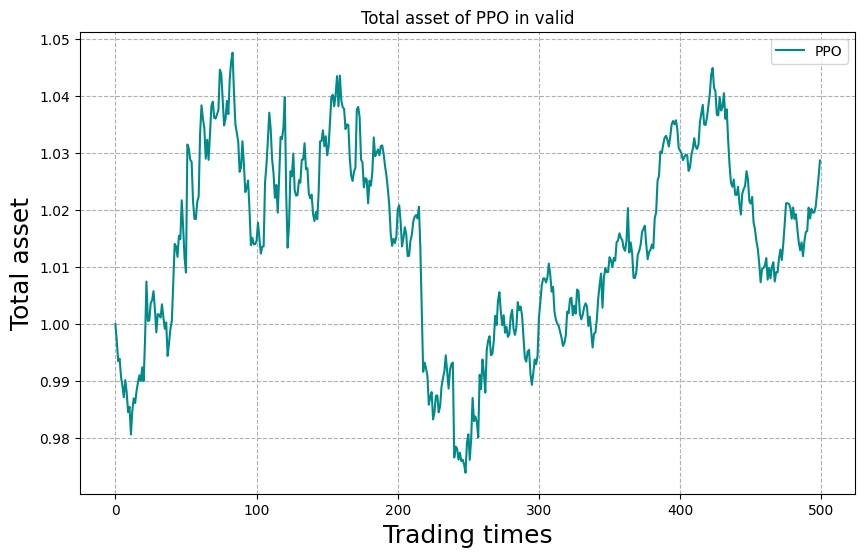

In [ ]:
import ray
from ray.tune.registry import register_env
from trademaster.environments.portfolio_management.environment import PortfolioManagementEnvironment
def env_creator(env_name):
    if env_name == 'portfolio_management':
        env = PortfolioManagementEnvironment
    else:
        raise NotImplementedError
    return env
ray.init(ignore_reinit_error=True)
register_env("portfolio_management", lambda config: env_creator("portfolio_management")(config))
trainer.train_and_valid()

## Step 6: Test

(f pid=14541) Test Best Episode


array([ 0.00000000e+00, -4.09564531e-03,  6.06773198e-04, -3.16967257e-03,
       -1.12141619e-04,  1.11708884e-03, -2.28493180e-03, -1.71686560e-04,
        1.70222680e-03, -2.18947542e-03,  4.69566802e-04, -2.47532173e-03,
       -6.69518881e-04, -1.35427898e-03, -1.59642744e-03,  1.27121804e-04,
       -1.32910875e-03,  5.14760687e-03,  1.74520466e-03,  2.91590714e-03,
        3.43272089e-04, -4.81268551e-04, -9.02616130e-04,  3.62639250e-03,
        7.21881666e-04, -2.69208461e-03, -5.62917090e-04, -2.40632183e-04,
       -2.13320861e-03, -1.59022212e-03, -2.60264157e-04,  8.48185846e-04,
       -3.60402470e-03, -1.95183255e-04, -6.89547029e-04, -1.57610053e-03,
       -1.72964899e-03,  5.60665458e-04,  3.36066587e-03,  1.24616577e-03,
       -1.27672184e-03, -1.47494319e-03,  2.02060186e-04,  3.33454588e-03,
        2.79001346e-03, -1.44747329e-03,  2.11864364e-04,  3.85837523e-03,
        1.16388387e-03,  1.42898475e-03,  1.12141776e-03, -8.42760065e-04,
       -1.60988639e-04, -

(f pid=14541) +--------------+-------------+------------+--------------+
(f pid=14541) | Total Return | Sharp Ratio | Volatility | Max Drawdown |
(f pid=14541) +--------------+-------------+------------+--------------+
(f pid=14541) |  1.222946%   |   1.168070  | 0.172332%  |  1.666513%   |
(f pid=14541) +--------------+-------------+------------+--------------+


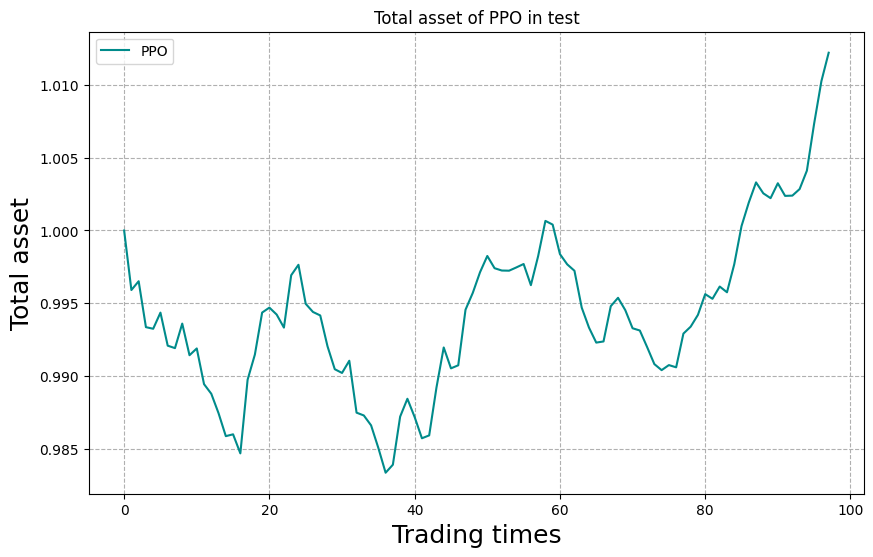

In [ ]:
import ray
from ray.tune.registry import register_env
from trademaster.environments.portfolio_management.environment import PortfolioManagementEnvironment
def env_creator(env_name):
    if env_name == 'portfolio_management':
        env = PortfolioManagementEnvironment
    else:
        raise NotImplementedError
    return env
ray.init(ignore_reinit_error=True)
register_env("portfolio_management", lambda config: env_creator("portfolio_management")(config))
trainer.test()

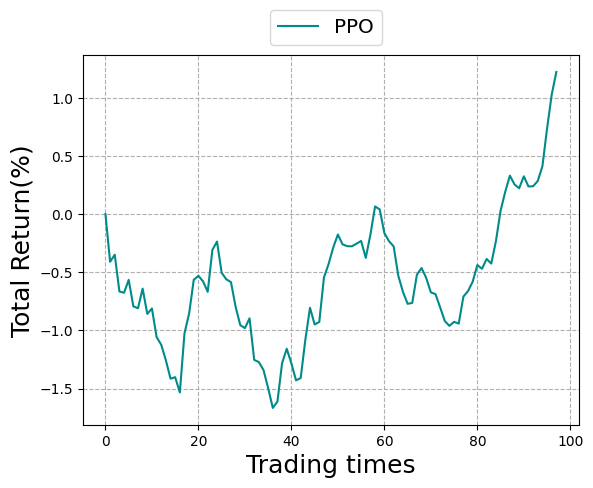

In [ ]:
plot(trainer.test_environment.save_asset_memory(),alg="PPO")

# Tutorial 5: ETEO for Order Execution
This tutorial is to demonstrate an example of using ETEO for order execution

## Step 1: Import Packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import sys
from pathlib import Path
import os
import torch

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)

import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
from collections import Counter
from trademaster.utils import set_seed
set_seed(2023)

## Step 2: Import Configs

In [ ]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "TradeMaster", "configs", "order_execution",
                                                 "order_execution_BTC_eteo_eteo_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")
parser.add_argument("--test_style", type=str, default="-1")
args,_ = parser.parse_known_args()

cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

## Step 3: Build Dataset

In [ ]:
dataset = build_dataset(cfg)

The 18_th segment length is less than the min length so it won't be tested


## Step 4: Build Environment

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))
train_environment.df.head()

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
0,2021-04-07 11:33:41.122161+00:00,55896.285,0.01,4.448599e+06,3.899402e+06,-8.945138e-08,-0.000065,-0.000073,-0.000154,-0.000162,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1176.72998,0.0
1,2021-04-07 11:34:41.122161+00:00,55948.685,1.43,1.243244e+06,3.606502e+06,-1.277957e-05,-0.000013,-0.000242,-0.000242,-0.000259,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,2021-04-07 11:35:41.122161+00:00,56013.785,0.01,3.069094e+06,1.575759e+06,-8.926374e-08,-0.000009,-0.000070,-0.000088,-0.000173,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
3,2021-04-07 11:36:41.122161+00:00,55903.575,7.17,1.220819e+06,1.321487e+06,-6.412827e-05,-0.000182,-0.000188,-0.000225,-0.000310,...,0.0,312.040009,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,2021-04-07 11:37:41.122161+00:00,55899.995,0.01,2.011287e+06,3.083005e+06,-8.944544e-08,-0.000129,-0.000130,-0.000143,-0.000201,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0


## Step 5: Build Net

In [ ]:
action_dim = train_environment.action_dim
state_dim = train_environment.state_dim

cfg.act.update(dict(action_dim=action_dim, state_dim=state_dim))
cfg.cri.update(dict(action_dim=action_dim, state_dim=state_dim))

act = build_net(cfg.act)
cri = build_net(cfg.cri)

## Step 6: Build Optimizer

In [ ]:
act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
cri_optimizer = None

## Step 7: Build Loss

In [ ]:
criterion = build_loss(cfg)

## Step 8: Build Transition

In [ ]:
transition = build_transition(cfg)

## Step 9: Build Agent

In [ ]:
agent = build_agent(cfg, default_args=dict(action_dim=action_dim,state_dim=state_dim,act=act,cri=cri,act_optimizer=act_optimizer,cri_optimizer=cri_optimizer,criterion=criterion,transition=transition,device=device))

## Step 10: Build Trainer

In [ ]:
trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))

## Step 11: RL Agent Training
Train the ETTO agent based on the config and save results in workdir

Train Episode: [1/2]
+--------------+--------------+-----------------+
|  Cash Left   |     TWAP     | Cash Left Ratio |
+--------------+--------------+-----------------+
| 37461.153500 | 41059.122004 |    -8.762897%   |
+--------------+--------------+-----------------+
Valid Episode: [1/2]
+--------------+--------------+-----------------+
|  Cash Left   |     TWAP     | Cash Left Ratio |
+--------------+--------------+-----------------+
| 38610.495450 | 37244.542270 |    3.667526%    |
+--------------+--------------+-----------------+
Train Episode: [2/2]
+--------------+--------------+-----------------+
|  Cash Left   |     TWAP     | Cash Left Ratio |
+--------------+--------------+-----------------+
| 37461.153500 | 41059.122004 |    -8.762897%   |
+--------------+--------------+-----------------+
Valid Episode: [2/2]
+--------------+--------------+-----------------+
|  Cash Left   |     TWAP     | Cash Left Ratio |
+--------------+--------------+-----------------+
| 38610.495450 |

<Figure size 2000x1200 with 0 Axes>

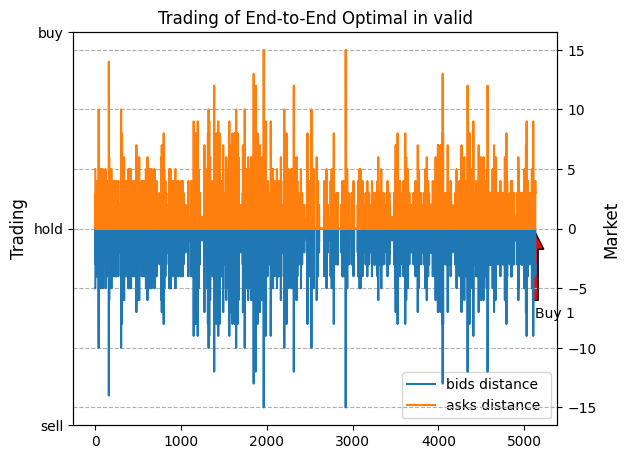

In [ ]:
trainer.train_and_valid()

## Step 12: RL Agent Testing

Test Best Episode
+--------------+--------------+-----------------+
|  Cash Left   |     TWAP     | Cash Left Ratio |
+--------------+--------------+-----------------+
| 44920.363750 | 39814.366548 |    12.824509%   |
+--------------+--------------+-----------------+


{'cash_left': 44920.36374997031,
 'TWAP_value': 39814.36654819225,
 'cash_left_by_tick': [100000,
  100000,
  100000,
  100000,
  100000,
  100000,
  100000,
  100000,
  100000,
  100000,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000

<Figure size 2000x1200 with 0 Axes>

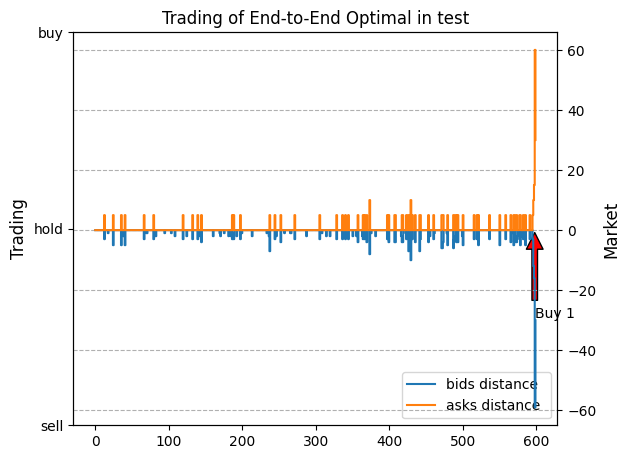

In [ ]:
trainer.test()

# Tutorial 6: DDQN for High Frequency BTC Trading
We show how to train Double DQN for high frequency trading on Bitcoin.

## Step 1: Import Packages
Modify the system path and load the corresponding packages and functions

In [ ]:
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)

import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
from trademaster.utils import plot
from trademaster.utils import set_seed
set_seed(2023)

## Step 2: Load Configs
Load default config from the file configs/high_frequency_trading/high_frequency_trading_BTC_dqn_dqn_adam_mse.py

In [ ]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "TradeMaster", "configs", "high_frequency_trading", "high_frequency_trading_BTC_dqn_dqn_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")

args, _ = parser.parse_known_args()
cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

## Step 3: Build Dataset

In [ ]:
dataset = build_dataset(cfg)

## Step 4: Build Reinforcement Learning Environments
Build environments based on cfg and predefined dataset

In [ ]:
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))
cfg.environment = cfg.train_environment
train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))
train_environment.df.head()

,bid1_price,bid1_size,bid2_price,bid2_size,bid3_price,bid3_size,bid4_price,bid4_size,bid5_price,bid5_size,...,imxd_60,cntp_10,cntp_30,cntp_60,cntn_10,cntn_30,cntn_60,cntd_10,cntd_30,cntd_60
0,23794.3,0.900828,23792.9,0.018588,23792.8,0.007388,23792.1,0.042018,23792.0,0.000300,...,1.193895,0.268138,0.963686,0.800684,-0.418841,-0.017993,-0.189727,0.469470,0.745885,0.877378
1,23794.3,0.000878,23793.2,0.014988,23793.1,0.147063,23792.8,0.007388,23792.0,0.000300,...,1.193895,0.268138,0.963686,0.800684,-1.027695,-0.017993,-0.358007,0.891105,0.745885,1.031828
2,23794.3,0.000878,23793.2,0.014988,23792.8,0.007388,23792.0,0.000300,23791.8,0.147071,...,1.139902,0.268138,1.257798,0.976534,-1.027695,-0.017993,-0.526286,0.891105,0.969180,1.340727
3,23794.3,0.000878,23793.2,0.014988,23792.8,0.007388,23792.0,0.000300,23791.8,0.147071,...,1.139902,0.268138,1.257798,0.800684,-1.027695,-0.017993,-0.526286,0.891105,0.969180,1.186278
4,23794.3,0.000878,23793.2,0.014988,23792.8,0.007388,23792.0,0.000300,23791.8,0.147071,...,1.112905,0.268138,0.963686,0.800684,-1.027695,-0.017993,-0.694566,0.891105,0.745885,1.340727


## Step 5: Build Net
Update information about the state and action dimension. Create networks and optimizer for Double DQN

In [ ]:
action_dim = train_environment.action_dim
state_dim = train_environment.state_dim

cfg.act.update(dict(action_dim=action_dim, state_dim=state_dim))
act = build_net(cfg.act)
act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
if cfg.cri:
    cfg.cri.update(dict(action_dim=action_dim, state_dim=state_dim))
    cri = build_net(cfg.cri)
    cri_optimizer = build_optimizer(cfg, default_args=dict(params=cri.parameters()))
else:
    cri = None
    cri_optimizer = None

## Step 6: Build Loss

In [ ]:
criterion = build_loss(cfg)

## Step 7: Build Agent

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = build_agent(cfg,default_args=dict(action_dim=action_dim,state_dim=state_dim,act=act,cri=cri,act_optimizer=act_optimizer,cri_optimizer=cri_optimizer,
                        criterion=criterion,device=device))

## Step 8: Build Trainer
Build trainer from config and create work directionary to save the result, model and config

In [ ]:
trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))

cfg.dump(osp.join(ROOT, "TradeMaster", cfg.work_dir, osp.basename(args.config)))

| Arguments Keep work_dir: /content/TradeMaster/work_dir/high_frequency_trading_BTC_high_frequency_trading_dqn_ddqn_adam_mse


## Step 9: RL Agent Training
Train the Double DQN agent based on the config and save results in workdir

In [ ]:
trainer.train_and_valid()

Train Episode: [1/10]
+---------------+--------------+------------+--------------+
| Profit Margin | Sharp Ratio  | Volatility | Max Drawdown |
+---------------+--------------+------------+--------------+
|  -19.710863%  | -2792.392715 | 0.003066%  |  19.713213%  |
+---------------+--------------+------------+--------------+
+---------------+--------------+------------+--------------+
| Profit Margin | Sharp Ratio  | Volatility | Max Drawdown |
+---------------+--------------+------------+--------------+
|  -17.955225%  | -2142.013586 | 0.003603%  |  17.979934%  |
+---------------+--------------+------------+--------------+
Valid Episode: [1/10]
+--------------+------------+--------------+
| Total Return | Volatility | Max Drawdown |
+--------------+------------+--------------+
| -45.740756%  | 0.005121%  |  45.740756%  |
+--------------+------------+--------------+
Train Episode: [2/10]
+---------------+--------------+------------+--------------+
| Profit Margin | Sharp Ratio  | Volat

## Step 10: RL Agent Testing

In [ ]:
trainer.test()

Test Best Episode
+--------------+------------+--------------+
| Total Return | Volatility | Max Drawdown |
+--------------+------------+--------------+
|  0.064938%   | 0.007087%  |  0.546686%   |
+--------------+------------+--------------+


array([ 0.        , -0.01565856, -0.016     , ...,  0.        ,
        0.        ,  0.        ])

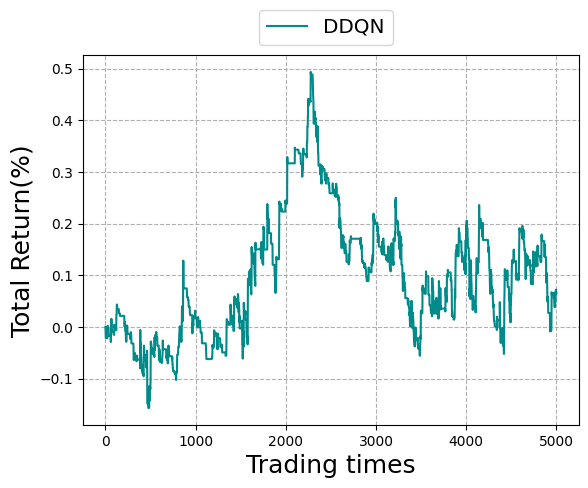

In [ ]:
plot(trainer.test_environment.save_asset_memoey(),alg="DDQN")